In [ ]:
# IANNwTF_Homework 06 - ResNet and DenseNet

import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, stride_count = 2):
        super(ResidualBlock, self).__init__()
        filter1, filter2, filter3 = filters    #filter1=64, filter2=64, filter3=256
        
        #First layer
        self.conv_1 = tf.keras.layers.Conv2D(filters=filter1, kernel_size=(1), strides=(stride_count,stride_count))
        self.batchnorm_1 = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image
        self.activation_1 = tf.keras.layers.Activation('relu')
        #Second layer
        self.conv_2 = tf.keras.layers.Conv2D(filters=filter2, kernel_size=(3), strides=(stride_count,stride_count), padding='same')
        self.batchnorm_2 = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image
        self.activation_2 = tf.keras.layers.Activation('relu')

        #Third layer
        self.conv_3 = tf.keras.layers.Conv2D(filters=filter3, kernel_size=(1), strides=(stride_count,stride_count), padding='valid')
        self.batchnorm_3 = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image
        self.activation_3 = tf.keras.layers.Activation('relu')

        #Skip step layer (converting input to same size as output for addition)
        #Choose s to get the appropriate size to match x_skip.shape to x.shape.
        #Formula used to determine output size: floor(((n-f)/s) + 1) = output_dim, where n is the original input dimension(assuming same height or width), f is the kernel size, and s is the stride.
        #x_skip.shape:  (64, 32, 32, 64) x.shape:  (64, 4, 4, 256) <- based on testing readout. Goal: convert dim of 32 to dim of 4
        #n = 32, f = 1 (1x1 convolution), output_dim = 4
        #((32-1)/s)+ 1 = 4, pick s = 8
        #floor(31/8 + 1) = 3
        self.conv_1x1 = tf.keras.layers.Conv2D(filters=filter3, kernel_size=(1), strides=(8,8), padding='valid')  #use filter3 to convert number of channels of input to match the third layer
        self.batchnorm_skip = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image

    def call(self, x, training=True):
        x_skip = x #duplicating input to be used in skip step
      
        #First layer calls
        x = self.conv_1(x)
        x = self.batchnorm_1(x, training)
        x = self.activation_1(x)

        #Second layer calls
        x = self.conv_2(x)
        x = self.batchnorm_2(x, training)
        x = self.activation_2(x)

        #Third layer calls
        x = self.conv_3(x)
        x = self.batchnorm_3(x, training)
      
        #if input shape differs from output shape, modify input before addition
        
        #print("x_skip.shape: ", x_skip.shape, "x.shape: ", x.shape)
        if(x_skip.shape != x.shape):
            x_skip = self.conv_1x1(x_skip)
            x_skip = self.batchnorm_skip(x_skip, training)
        #print("x_skip.shape: ", x_skip.shape, "x.shape: ", x.shape)
        #perform addition of input to output before activation function
        x = tf.keras.layers.add([x, x_skip])
        x = self.activation_3(x)

        return x

In [ ]:
class ResNet(tf.keras.Model):
    def __init__(self, resblock_count_1, block_filters_1, resblock_count_2, block_filters_2, resblock_count_3, block_filters_3, resblock_count_4, block_filters_4):
        super(ResNet, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters=64, #WHAT IS THE APPROPRIATE FILTER COUNT/KERNEL SIZE
                                         kernel_size=3,
                                         padding="same",
                                         input_shape=(32, 32, 3), 
                                         kernel_regularizer="l2",
                                         bias_regularizer="l2")
        self.resblock_list_1 = [ResidualBlock(block_filters_1) for each in range(resblock_count_1)]
        self.resblock_list_2 = [ResidualBlock(block_filters_2) for each in range(resblock_count_2)]
        self.resblock_list_3 = [ResidualBlock(block_filters_3) for each in range(resblock_count_3)]
        self.resblock_list_4 = [ResidualBlock(block_filters_4) for each in range(resblock_count_4)]
        self.res_list_len_1 = resblock_count_1          #TO BE USED FOR THE RESIDUAL BLOCKS CALL LOOP
        self.res_list_len_2 = resblock_count_2
        self.res_list_len_3 = resblock_count_3
        self.res_list_len_4 = resblock_count_4 
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")
        self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)

    def call(self, x, training=True):
        x = self.conv_1(x)
        for each in range(self.res_list_len_1):
          x = self.resblock_list_1[each](x, training)
        for each in range(self.res_list_len_2):
          x = self.resblock_list_2[each](x, training)
        for each in range(self.res_list_len_3):
          x = self.resblock_list_3[each](x, training)
        for each in range(self.res_list_len_4):
          x = self.resblock_list_4[each](x, training)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # if using dropout, add: training=True
  with tf.GradientTape() as tape:
    # for dropout, use: prediction = model(input, training)
    prediction = model(input)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # if use dropout, add training=False
  test_losses = []
  test_accuracies = []
    
  for (input, target) in test_data:
    # prediction = model(input, training)
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    
    # print('line 20: sample_test_loss is ', sample_test_loss)
    # axis=0 is the batch_size, axis=1 is the one-hot encoding of the labels
        
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    
    test_losses.append(sample_test_loss.numpy())
    # compute the sample_test_accuracy for each batch before appending
    test_accuracies.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)

  return test_loss, test_accuracy    

In [ ]:
# visualize accuracy and loss for train_ds & test_ds
def plot(train_losses, test_losses, test_accuracies, figsize=(10,3)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
  axes[0].plot(train_losses, label='train')
  axes[0].plot(test_losses, label='test')
  axes[0].set_xlabel('Epoches')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss', fontsize=20)
  axes[0].legend()
  axes[1].plot(test_accuracies)
  axes[1].set_xlabel('Epoches')
  axes[1].set_ylabel('Accuracy')
  plt.ylim(0,1.0)
  axes[1].set_title('Accuracy' + str(round(np.max(test_accuracies))), fontsize=20)
  plt.show()

In [ ]:
# implementation credits go to Group 16's Week04 homework
# option 1: gaussian standard distribution
def norm_std():
  return tf.image.per_image_standardization(image)

# option 2: normalize to (0,1)
def norm_0_1(x):
  max = 255
  min = 0
  result = tf.math.subtract(x, min)
  norm_image = tf.math.divide(result, (max - min))
  return norm_image

# option 3: normalize to (-1,1)
def norm_neg_1(x):
  result = norm_0_1(x)
  result = tf.math.multiply(result, 2)
  norm_image = tf.math.subtract(result, 1)
  return norm_image

In [ ]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# train_ds, test_ds = tf.keras.datasets.cifar10.load_data()

# train_ds = train_ds[:10000]
# test_ds = test_ds[11000:15000]
# Here we take the first 10000 images for training, another 4000 images for testing
# as a starting point to build the whole pipeline 
# train_images = train_images[:10000]
# train_labels = train_labels[:10000]
# test_images = test_images[11000:15000]
# test_labels = test_labels[11000:15000]

170500096/170498071 [==============================] - 4s 0us/step


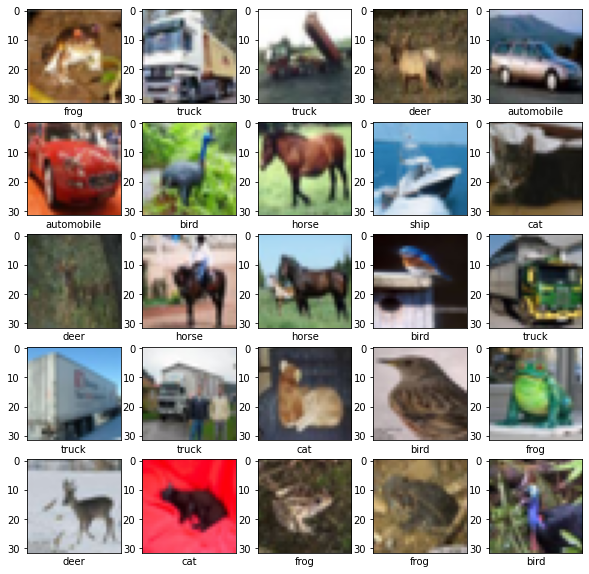

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0])) # --> max pixel value: 255
print(np.min(train_images[0]))

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
255
0


In [ ]:
# confirming the pixel range of the images: (0,255)
# this will be used for normalization
max = 0
min = 0 
for train_image in train_images:
  if np.max(train_image) > max:
    max = np.max(train_image)
  if np.min(train_image) < min:
    min = np.min(train_image)
print(max, min)

255 0


In [ ]:
# preprocess train_ds
# Unlike the previous homework, the current images have the same size --> no resizing needed
# Here only normalization of pixel values to (-1,1) and one-hot encoding the label are performed
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)
#train_ds_images = train_ds_images.map(lambda img : tf.reshape(img, (-1,)))
train_ds_images = train_ds_images.map(lambda image: norm_neg_1(image))
train_ds_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_ds_labels = train_ds_labels.map(lambda label : tf.one_hot(label, 10))
train_ds_labels = train_ds_labels.map(lambda label: tf.reshape(label, (-1,)))

# repeat the above procedures for test_ds
test_ds_images = tf.data.Dataset.from_tensor_slices(test_images)
test_ds_images = test_ds_images.map(lambda image: norm_neg_1(image))
test_ds_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_ds_labels = test_ds_labels.map(lambda label : tf.one_hot(label, 10))
test_ds_labels = test_ds_labels.map(lambda label: tf.reshape(label, (-1,)))
# print(test_ds_labels)


train_ds = tf.data.Dataset.zip((train_ds_images, train_ds_labels))
train_ds_shuffle = train_ds.shuffle(buffer_size=10000)
train_ds_batched = train_ds_shuffle.batch(64)
train_ds_total = train_ds_batched.prefetch(tf.data.experimental.AUTOTUNE)

# repeat the above procedures for test_ds
test_ds = tf.data.Dataset.zip((test_ds_images, test_ds_labels))
test_ds_shuffle = test_ds.shuffle(buffer_size=4000)
test_ds_batched = test_ds.batch(64)
test_ds_total = test_ds_batched.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Helper function to test the generated dataset from tensors
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)
print(train_ds_images)

<TensorSliceDataset shapes: (32, 32, 3), types: tf.uint8>


testing once on test data before start
check how model performs on train data once before start
Starting training
Epoch:  0
running average is  2.4555624
Train loss in Epoch  0  is  2.4555624
Test loss in Epoch  0  is  2.467996
Test accuracy in Epoch  0  is  0.16162420382165604


Epoch:  1
running average is  2.1990685
Train loss in Epoch  1  is  2.1990685
Test loss in Epoch  1  is  2.2596917
Test accuracy in Epoch  1  is  0.18859474522292993


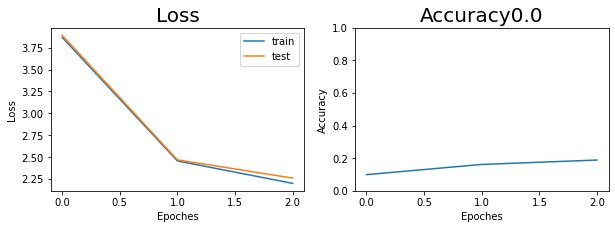

Epoch:  2
running average is  2.2063086
Train loss in Epoch  2  is  2.2063086
Test loss in Epoch  2  is  2.1510112
Test accuracy in Epoch  2  is  0.21675955414012738


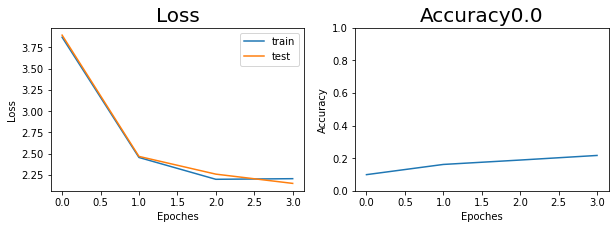

Epoch:  3
running average is  2.137097
Train loss in Epoch  3  is  2.137097
Test loss in Epoch  3  is  2.116184
Test accuracy in Epoch  3  is  0.23427547770700638


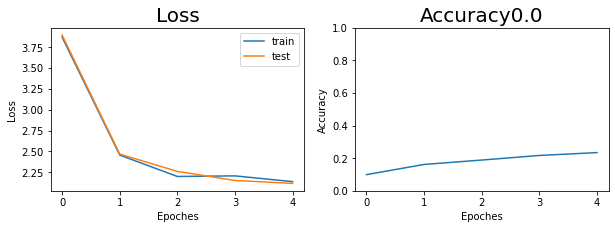

Epoch:  4
running average is  2.0751085
Train loss in Epoch  4  is  2.0751085
Test loss in Epoch  4  is  2.0779948
Test accuracy in Epoch  4  is  0.2532842356687898


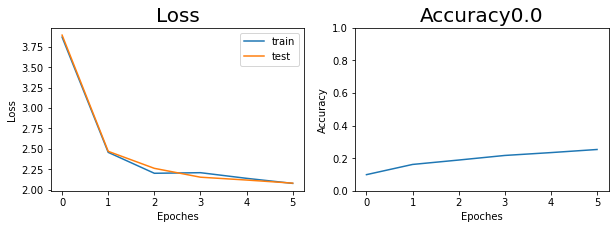

Epoch:  5
running average is  2.027818
Train loss in Epoch  5  is  2.027818
Test loss in Epoch  5  is  2.0462306
Test accuracy in Epoch  5  is  0.2726910828025478


Epoch:  6
running average is  1.954201
Train loss in Epoch  6  is  1.954201
Test loss in Epoch  6  is  1.9642384
Test accuracy in Epoch  6  is  0.29607882165605093


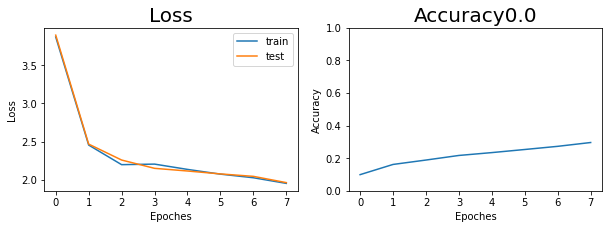

Epoch:  7
running average is  1.9172502
Train loss in Epoch  7  is  1.9172502
Test loss in Epoch  7  is  1.9305696
Test accuracy in Epoch  7  is  0.3099124203821656


Epoch:  8
running average is  1.8749679
Train loss in Epoch  8  is  1.8749679
Test loss in Epoch  8  is  1.8961298
Test accuracy in Epoch  8  is  0.3183718152866242


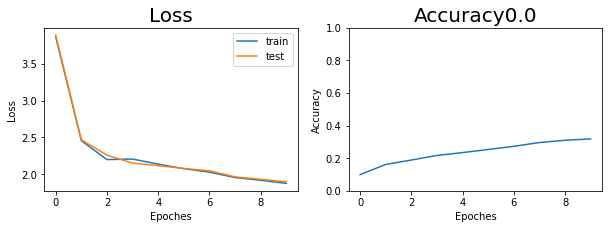

Epoch:  9
running average is  1.853351
Train loss in Epoch  9  is  1.853351
Test loss in Epoch  9  is  1.8574018
Test accuracy in Epoch  9  is  0.3335987261146497


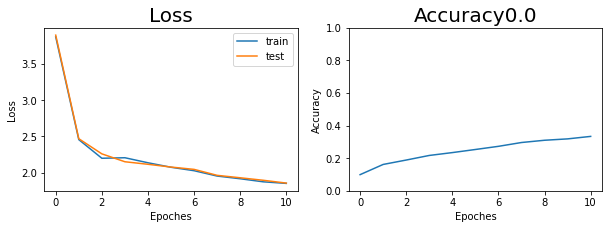

Epoch:  10
running average is  1.8157191
Train loss in Epoch  10  is  1.8157191
Test loss in Epoch  10  is  1.8134894
Test accuracy in Epoch  10  is  0.3522093949044586


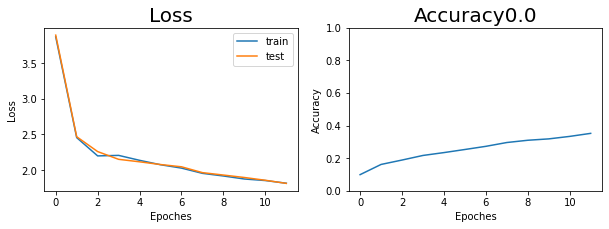

Epoch:  11
running average is  1.7336519
Train loss in Epoch  11  is  1.7336519
Test loss in Epoch  11  is  1.7848717
Test accuracy in Epoch  11  is  0.3655453821656051


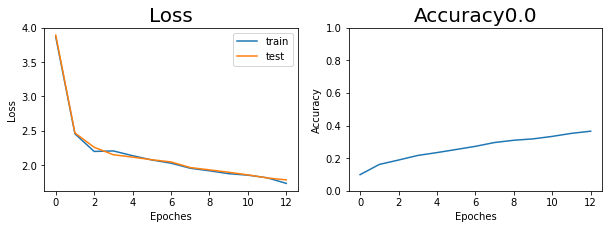

Epoch:  12
running average is  1.7457409
Train loss in Epoch  12  is  1.7457409
Test loss in Epoch  12  is  1.7696397
Test accuracy in Epoch  12  is  0.37589570063694266


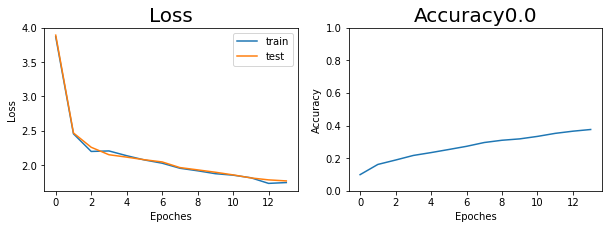

Epoch:  13
running average is  1.6877444
Train loss in Epoch  13  is  1.6877444
Test loss in Epoch  13  is  1.7337034
Test accuracy in Epoch  13  is  0.3818670382165605


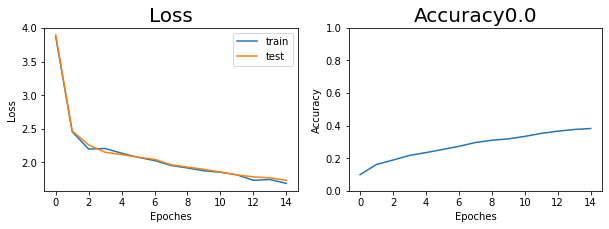

Epoch:  14
running average is  1.6842825
Train loss in Epoch  14  is  1.6842825
Test loss in Epoch  14  is  1.7594919
Test accuracy in Epoch  14  is  0.3840565286624204


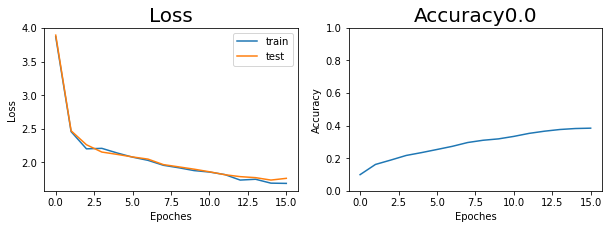

Epoch:  15
running average is  1.6273508
Train loss in Epoch  15  is  1.6273508
Test loss in Epoch  15  is  1.7313392
Test accuracy in Epoch  15  is  0.3963972929936306


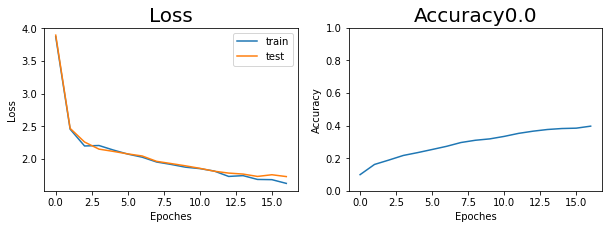

Epoch:  16
running average is  1.5626974
Train loss in Epoch  16  is  1.5626974
Test loss in Epoch  16  is  1.7165946
Test accuracy in Epoch  16  is  0.40674761146496813


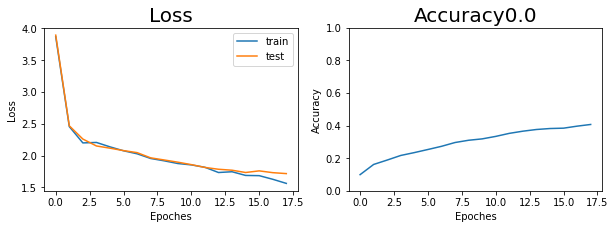

Epoch:  17
running average is  1.5695579
Train loss in Epoch  17  is  1.5695579
Test loss in Epoch  17  is  1.6765523
Test accuracy in Epoch  17  is  0.4065485668789809


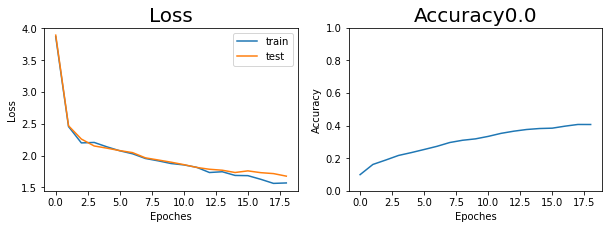

Epoch:  18
running average is  1.5968591
Train loss in Epoch  18  is  1.5968591
Test loss in Epoch  18  is  1.675679
Test accuracy in Epoch  18  is  0.41839171974522293


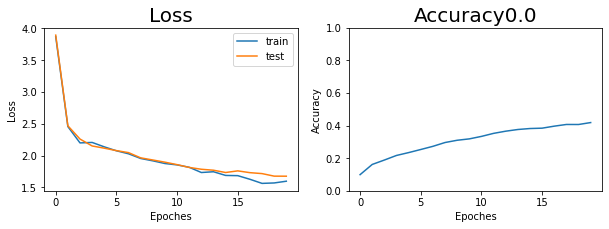

Epoch:  19
running average is  1.5298547
Train loss in Epoch  19  is  1.5298547
Test loss in Epoch  19  is  1.6936386
Test accuracy in Epoch  19  is  0.41620222929936307


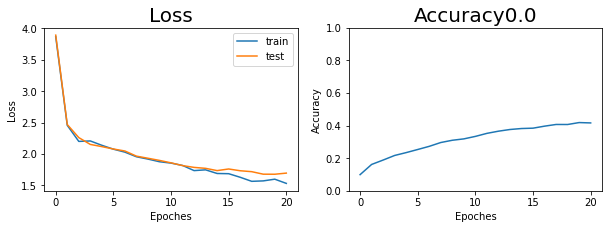

Epoch:  20
running average is  1.4971058
Train loss in Epoch  20  is  1.4971058
Test loss in Epoch  20  is  1.691794
Test accuracy in Epoch  20  is  0.412718949044586


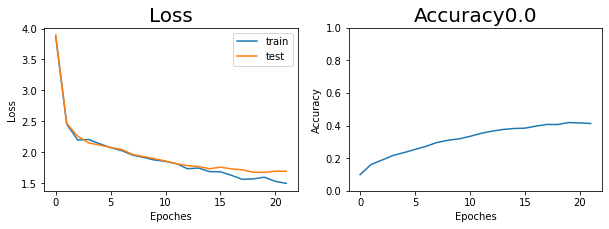

Epoch:  21
running average is  1.5063967
Train loss in Epoch  21  is  1.5063967
Test loss in Epoch  21  is  1.6775558
Test accuracy in Epoch  21  is  0.4182921974522293


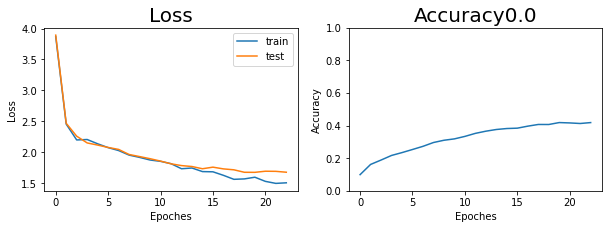

Epoch:  22
running average is  1.4544797
Train loss in Epoch  22  is  1.4544797
Test loss in Epoch  22  is  1.6966566
Test accuracy in Epoch  22  is  0.41908837579617836


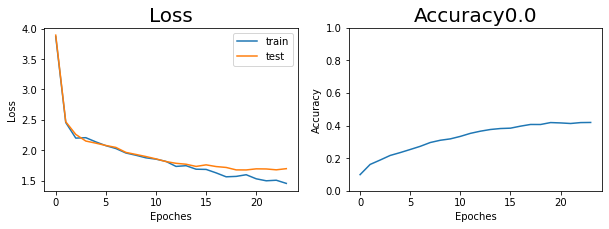

Epoch:  23
running average is  1.3536788
Train loss in Epoch  23  is  1.3536788
Test loss in Epoch  23  is  1.6974847
Test accuracy in Epoch  23  is  0.42436305732484075


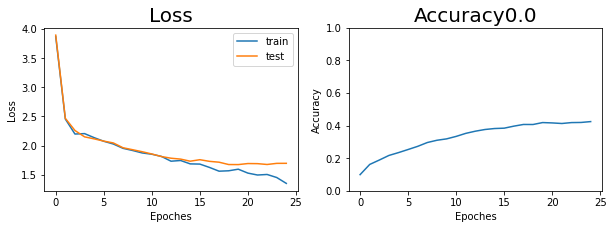

Epoch:  24
running average is  1.3669095
Train loss in Epoch  24  is  1.3669095
Test loss in Epoch  24  is  1.6923082
Test accuracy in Epoch  24  is  0.4287420382165605


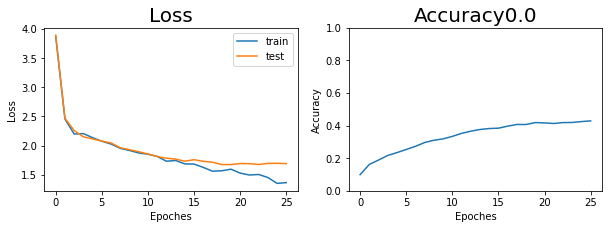

Epoch:  25
running average is  1.3686668
Train loss in Epoch  25  is  1.3686668
Test loss in Epoch  25  is  1.7275406
Test accuracy in Epoch  25  is  0.42296974522292996


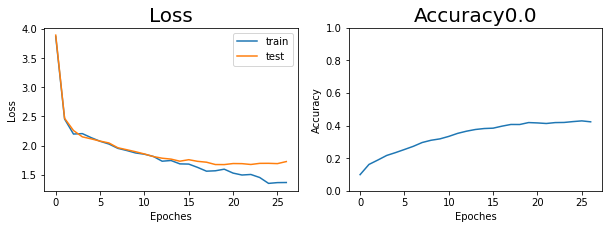

Epoch:  26
running average is  1.2929159
Train loss in Epoch  26  is  1.2929159
Test loss in Epoch  26  is  1.7188277
Test accuracy in Epoch  26  is  0.4189888535031847


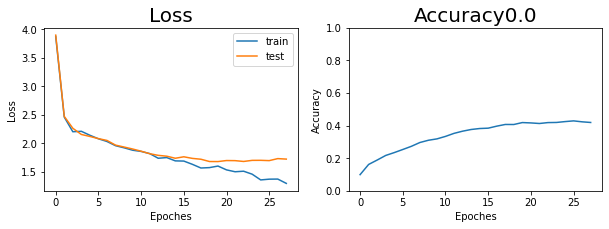

Epoch:  27
running average is  1.3635314
Train loss in Epoch  27  is  1.3635314
Test loss in Epoch  27  is  1.7350975
Test accuracy in Epoch  27  is  0.4148089171974522


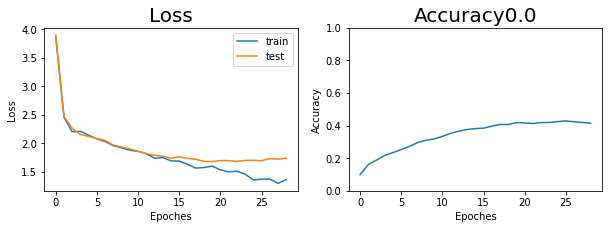

Epoch:  28
running average is  1.268968
Train loss in Epoch  28  is  1.268968
Test loss in Epoch  28  is  1.7492466
Test accuracy in Epoch  28  is  0.4239649681528662


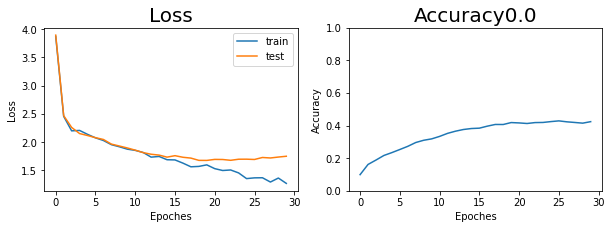

Epoch:  29
running average is  1.2253149
Train loss in Epoch  29  is  1.2253149
Test loss in Epoch  29  is  1.7652391
Test accuracy in Epoch  29  is  0.4280453821656051


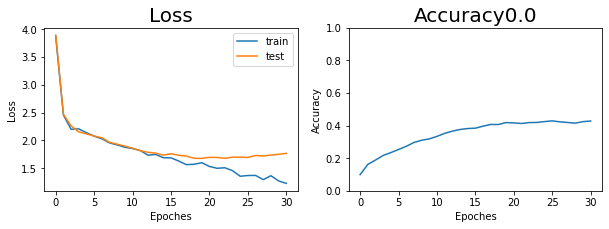

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.0001
running_average_factor = 0.95
block_count_1 = 3
block_filters_1 = (64, 64, 256)
block_count_2 = 4
block_filters_2 = (128, 128, 512)
block_count_3 = 6
block_filters_3 = (256, 256, 1024)
block_count_4 = 3
block_filters_4 = (512, 512, 2048)

# Initialize the model
model = ResNet(block_count_1, block_filters_1, block_count_2, block_filters_2, block_count_3, block_filters_3, block_count_4, block_filters_4)
# Define the loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization
train_losses = []

test_losses = []
test_accuracies =[]

print("testing once on test data before start")
test_loss, test_accuracy = test(model, test_ds_total, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print("check how model performs on train data once before start")
train_loss, _ = test(model, train_ds_total, cross_entropy_loss)
train_losses.append(train_loss)

# Train for num_epochs
print("Starting training")
for epoch in range(num_epochs):
  print('Epoch: ', str(epoch))

  # training
  running_average = 0
  for (sample, target) in train_ds_total:
    train_loss = train_step(model, sample, target, cross_entropy_loss, optimizer)
    running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
  print('running average is ', tf.get_static_value(running_average))
  train_losses.append(tf.get_static_value(running_average))
  print('Train loss in Epoch ', epoch, ' is ', tf.get_static_value(running_average))

  # testing
  test_loss, test_accuracy = test(model, test_ds_total, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print('Test loss in Epoch ', epoch, ' is ', test_loss)
  print('Test accuracy in Epoch ', epoch, ' is ', test_accuracy)
  plot(train_losses, test_losses, test_accuracies)